# Analzying economic indicators of countries using World Bank Data

## Importing libraries and loading data

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import os
from scipy.stats import pearsonr

# Inspecting Data

In [2]:
#Loading the dataset
df=pd.read_csv("WorldBank.csv")
df.head()

,Country Name,Country Code,Region,IncomeGroup,Year,"Birth rate, crude (per 1,000 people)","Death rate, crude (per 1,000 people)",Electric power consumption (kWh per capita),GDP (USD),GDP per capita (USD),Individuals using the Internet (% of population),"Infant mortality rate (per 1,000 live births)",Life expectancy at birth (years),Population density (people per sq. km of land area),Unemployment (% of total labor force) (modeled ILO estimate)
0,Afghanistan,AFG,South Asia,Low income,2018,NaN,NaN,NaN,1.936300e+10,520.897,NaN,47.9,NaN,56.9378,1.542
1,Afghanistan,AFG,South Asia,Low income,2017,33.211,6.575,NaN,2.019180e+10,556.302,13.50,49.5,64.130,55.5960,1.559
2,Afghanistan,AFG,South Asia,Low income,2016,33.981,6.742,NaN,1.936260e+10,547.228,11.20,51.2,63.763,54.1971,1.634
3,Afghanistan,AFG,South Asia,Low income,2015,34.809,6.929,NaN,1.990710e+10,578.466,8.26,53.1,63.377,52.7121,1.679
4,Afghanistan,AFG,South Asia,Low income,2014,35.706,7.141,NaN,2.048490e+10,613.856,7.00,55.1,62.966,51.1148,1.735


In [3]:
df.info() #Gives us an idea of which columns have missing values
df.shape #Dataset has 12449 rows and 15 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12449 entries, 0 to 12448
Data columns (total 15 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   Country Name                                                  12449 non-null  object 
 1   Country Code                                                  12449 non-null  object 
 2   Region                                                        12449 non-null  object 
 3   IncomeGroup                                                   12449 non-null  object 
 4   Year                                                          12449 non-null  int64  
 5   Birth rate, crude (per 1,000 people)                          11440 non-null  float64
 6   Death rate, crude (per 1,000 people)                          11416 non-null  float64
 7   Electric power consumption (kWh per capita)                   5848 

(12449, 15)

In [4]:
column_names=list(df.columns)
#print(column_names)

From the above inspection, we can see that columns like ['Birth rate, crude (per 1,000 people)',
       'Death rate, crude (per 1,000 people)',
       'Electric power consumption (kWh per capita)', 'GDP (USD)',
       'GDP per capita (USD)',
       'Individuals using the Internet (% of population)',
       'Infant mortality rate (per 1,000 live births)',
       'Life expectancy at birth (years)',
       'Population density (people per sq. km of land area)',
       'Unemployment (% of total labor force) (modeled ILO estimate)'] have missing values. Let's find the proportion of missing values by column to decide what to do with them.

In [5]:
#Finding proportion of missing values by column in the dataset
print("Column Null %")
for column in column_names:
    prop=(df[column].isnull().sum()/len(df))*100
    print(column,round(prop,2),"%")


Column Null %
Country Name 0.0 %
Country Code 0.0 %
Region 0.0 %
IncomeGroup 0.0 %
Year 0.0 %
Birth rate, crude (per 1,000 people) 8.11 %
Death rate, crude (per 1,000 people) 8.3 %
Electric power consumption (kWh per capita) 53.02 %
GDP (USD) 23.06 %
GDP per capita (USD) 23.09 %
Individuals using the Internet (% of population) 59.32 %
Infant mortality rate (per 1,000 live births) 19.8 %
Life expectancy at birth (years) 10.23 %
Population density (people per sq. km of land area) 4.85 %
Unemployment (% of total labor force) (modeled ILO estimate) 58.17 %


In [6]:
#Renaming columns to more usable names
df=df.rename({'Country Name':'country_name',
            'Country Code':'country_code',
             'Region':'region',
             'IncomeGroup':'income_group',
             'Year':'year',
             'Birth rate, crude (per 1,000 people)':'birth_rate',
             'Death rate, crude (per 1,000 people)':'death_rate',
             'Electric power consumption (kWh per capita)':'power_consumption',
              'GDP (USD)':'gdp',
             'GDP per capita (USD)':'gdp_per_capita',
              'Individuals using the Internet (% of population)':'internet_penetration',
             'Infant mortality rate (per 1,000 live births)':'infant_mortality',
             'Life expectancy at birth (years)':'life_expectancy',
              'Population density (people per sq. km of land area)':'pop_density',
             'Unemployment (% of total labor force) (modeled ILO estimate)':'unemployment'},axis=1)

In [7]:
df.dtypes

country_name             object
country_code             object
region                   object
income_group             object
year                      int64
birth_rate              float64
death_rate              float64
power_consumption       float64
gdp                     float64
gdp_per_capita          float64
internet_penetration    float64
infant_mortality        float64
life_expectancy         float64
pop_density             float64
unemployment            float64
dtype: object

# Handling Missing Data

Since we have misisng data across multiple columns, we will employ multiple imputation to fill in the gaps. For multiple imputation with ease, we will use miceforest.


In [8]:
#Creating an imputer and using it to impute values in non-categorical columns which have missing data.

#Columns to impute
columns_to_fix=["birth_rate","death_rate","power_consumption","gdp","gdp_per_capita","internet_penetration","infant_mortality","life_expectancy","pop_density","unemployment"]

imp=IterativeImputer(max_iter=10,random_state=0)

# Fit and transform ONLY the selected columns
df[columns_to_fix] = imp.fit_transform(df[columns_to_fix])

#print(df.info())

We now have a dataset that is cleaned using multiple imputation. We can now begin exploratory data analysis and documentation of our obervations which will inform further analysis with respect to our project goals.

## Dealing with suspect values

This involves cleaning up any values that are not in line with the column header such as negative values. For instance, gdp per capita cannot be negative.

In [9]:
#First we will find count of negative values by column head
numeric_columns=['birth_rate', 'death_rate', 'power_consumption', 'gdp',
       'gdp_per_capita', 'internet_penetration', 'infant_mortality',
       'life_expectancy', 'pop_density', 'unemployment']
for column in numeric_columns:
    negative_mask=df[column]<0
    negative_value_count=negative_mask.sum()
    print(column+" has "+str(negative_value_count)+" negative values")

birth_rate has 0 negative values
death_rate has 0 negative values
power_consumption has 1379 negative values
gdp has 0 negative values
gdp_per_capita has 136 negative values
internet_penetration has 1713 negative values
infant_mortality has 190 negative values
life_expectancy has 0 negative values
pop_density has 143 negative values
unemployment has 39 negative values


In [10]:
#Now I replace negative values in columns containing negative data with 0.
negative_containing_columns=["power_consumption","gdp_per_capita","internet_penetration","infant_mortality","pop_density","unemployment"]
for i in negative_containing_columns:
    df.loc[df[i]<0,i]=0
    

# Exploring the data

In [11]:
df.describe()

,year,birth_rate,death_rate,power_consumption,gdp,gdp_per_capita,internet_penetration,infant_mortality,life_expectancy,pop_density,unemployment
count,12449.00000,12449.000000,12449.000000,12449.000000,1.244900e+04,12449.000000,12449.000000,12449.000000,12449.000000,12449.000000,12449.000000
mean,1989.00000,28.556368,10.616055,2851.048726,1.700740e+11,7937.988471,16.892476,51.660830,64.320434,314.845529,7.746255
std,17.03007,12.615292,5.264320,4031.692232,7.876528e+11,14417.227270,20.838540,45.753659,11.001361,1555.466818,4.377302
min,1960.00000,6.900000,1.127000,0.000000,8.824450e+06,0.000000,0.000000,0.000000,18.907000,0.000000,0.000000
25%,1974.00000,17.280000,7.024000,330.500690,2.503530e+09,703.785000,0.667113,15.000000,57.498000,19.712600,5.307063
50%,1989.00000,28.204000,9.623000,1647.510000,2.035600e+10,2923.080000,10.545299,39.300000,66.478000,66.023500,7.288000
75%,2004.00000,39.870000,12.349688,3690.590000,1.700740e+11,8475.960000,23.400000,74.500000,72.353400,162.964000,9.300000
max,2018.00000,58.227000,54.444000,54799.200000,2.050000e+13,189171.000000,100.000000,279.400000,88.060385,21389.100000,37.940000


In [12]:
#How many countires by income group?
df.groupby("income_group").country_name.nunique()

income_group
High income: OECD       32
High income: nonOECD    47
Low income              31
Lower middle income     48
Upper middle income     53
Name: country_name, dtype: int64

OECD= Organisation for Economic Cooperation and Development. A question to explore would be if being an OECD country affects GDP.

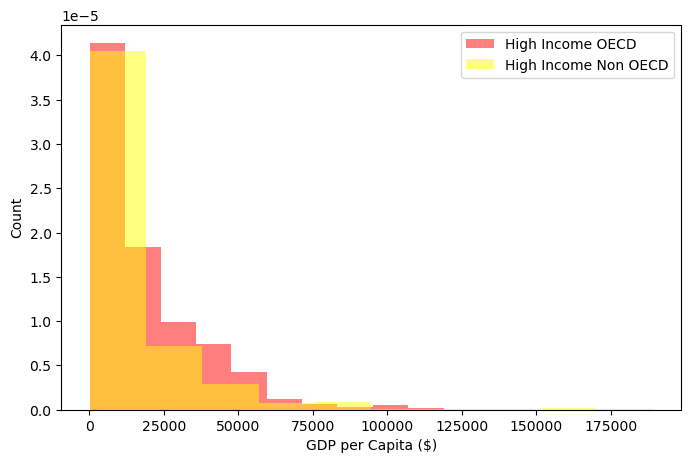

In [38]:
#Comparing Income distribution of a non-OECD high income country vs OECD high income country using histograms
hi_oecd_df=df.loc[df["income_group"]=="High income: OECD"]
hi_nonoecd_df=df.loc[df["income_group"]=="High income: nonOECD"]
plt.figure(figsize=(8,5))
plt.hist(hi_oecd_df.gdp_per_capita,color="red",label="High Income OECD",density=True,alpha=0.5)
plt.hist(hi_nonoecd_df.gdp_per_capita,color="yellow",label="High Income Non OECD",density=True,alpha=0.5)
plt.xlabel("GDP per Capita ($)")
plt.ylabel("Count")
plt.legend()
plt.show()

While the counts of gdp epr capita in the $0-$25000 is similar for both categories, we can see that high income OECD countries have higher numbers of $25000-$75000 earners.

# Slicing dataset for specificity
The dataset has data for 211 countries over a period of 58 years [1960-2018]. Visualizations and inferences will be cluttered and crowded if created for all 211 countries. To make our analysis focused, I will now slice the dataset to include only the top 10 economies as of 2025 (USA, China, Germany, India, Japan, UK, France, Brazil, Italy and Canada). This will help us understand the changes in the world's biggest economies over time.

In [13]:
#Creating new dataframe with countries of interest
top_ten_country_codes=["USA","CHN","DEU","IND","JPN","GBR","FRA","BRA","ITA","CAN"]
df2=df[df["country_code"].isin(top_ten_country_codes)]
#df2["country_code"]=df2["country_code"].reset_index(drop=True)
df2.country_name.unique()
df2.country_code.unique()

array(['BRA', 'CAN', 'CHN', 'FRA', 'DEU', 'IND', 'ITA', 'JPN', 'GBR',
       'USA'], dtype=object)

In [14]:
df2.info()
#df2.country_name.unique()

<class 'pandas.core.frame.DataFrame'>
Index: 590 entries, 1534 to 11858
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   country_name          590 non-null    object 
 1   country_code          590 non-null    object 
 2   region                590 non-null    object 
 3   income_group          590 non-null    object 
 4   year                  590 non-null    int64  
 5   birth_rate            590 non-null    float64
 6   death_rate            590 non-null    float64
 7   power_consumption     590 non-null    float64
 8   gdp                   590 non-null    float64
 9   gdp_per_capita        590 non-null    float64
 10  internet_penetration  590 non-null    float64
 11  infant_mortality      590 non-null    float64
 12  life_expectancy       590 non-null    float64
 13  pop_density           590 non-null    float64
 14  unemployment          590 non-null    float64
dtypes: float64(10), int64(1

# Visualizing aggregate statistics for economic indicators by country

D:\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pan

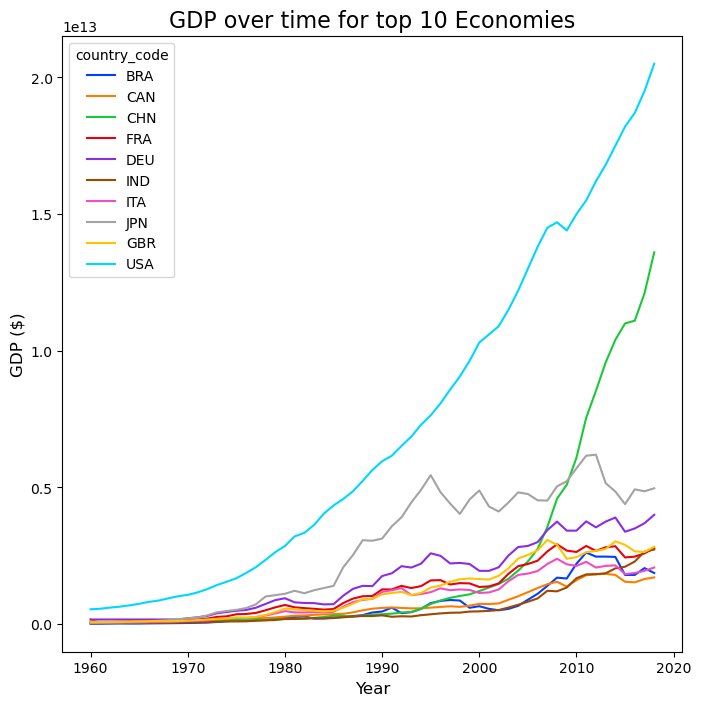

In [15]:
#Plotting GDP over time for top 10 countries
plotting_df=df2.copy()
plotting_df.dropna(inplace=True) # Drop rows with any NaN or inf
plotting_df.dropna(axis=1, inplace=True)  # Drop columns with any NaN or inf
#print(plotting_df.head())
fig,ax=plt.subplots(figsize=(8,8))
sns.lineplot(x="year",y="gdp",data=plotting_df,hue="country_code",palette="bright")
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("GDP ($)", fontsize=12)
ax.set_title("GDP over time for top 10 Economies",fontsize=16)
plt.show()

In the above plot, we see an exponential growth in GDP for USA in the mid 1970s. China saw a similar inflection point in the mid 2000s. Around the same time as China, the Indian economy started picking up speed.

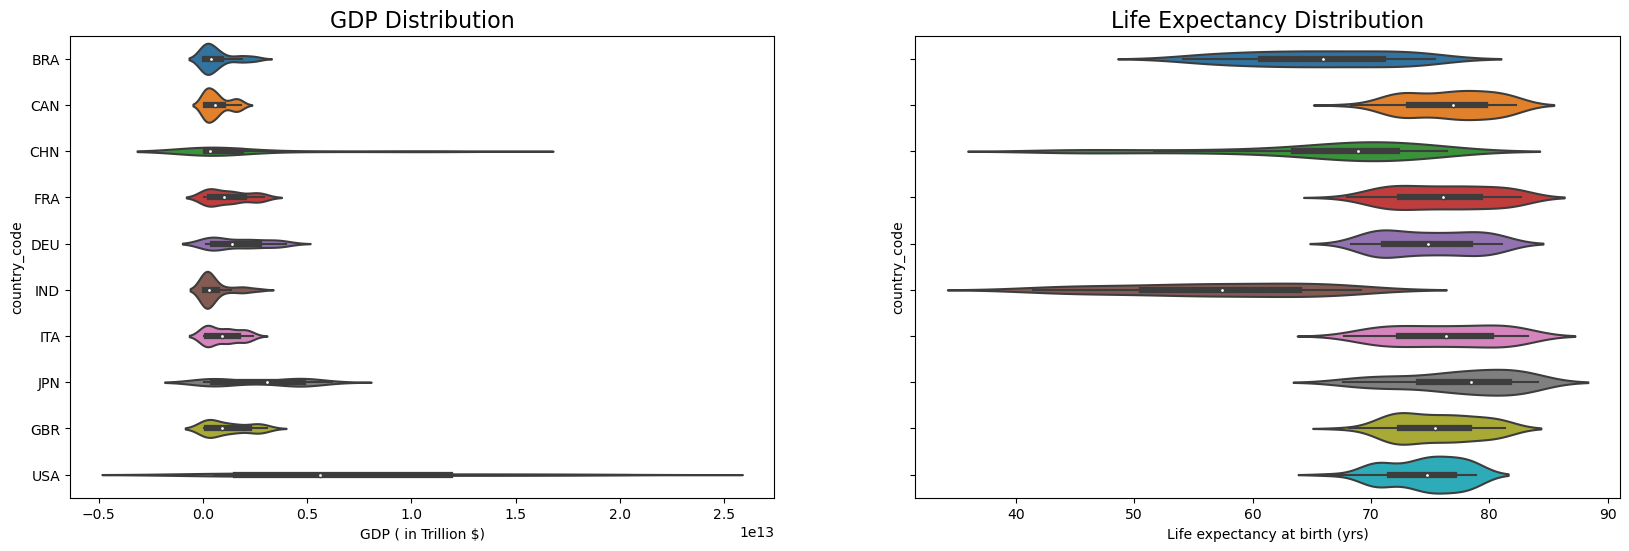

In [16]:
#Creating Violin plots of GDP and life expectancy by country
fig,ax=plt.subplots(1,2,sharey=True,figsize=(20,6))
ax[0]=sns.violinplot(ax=ax[0],x=plotting_df.gdp,y=plotting_df.country_code)
ax[0].set_xlabel("GDP ( in Trillion $)")
ax[1]=sns.violinplot(ax=ax[1],x=plotting_df.life_expectancy,y=plotting_df.country_code)
ax[1].set_xlabel("Life expectancy at birth (yrs)")
ax[0].set_title("GDP Distribution",fontsize=16)
ax[1].set_title("Life Expectancy Distribution",fontsize=16)
plt.show()

D:\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf

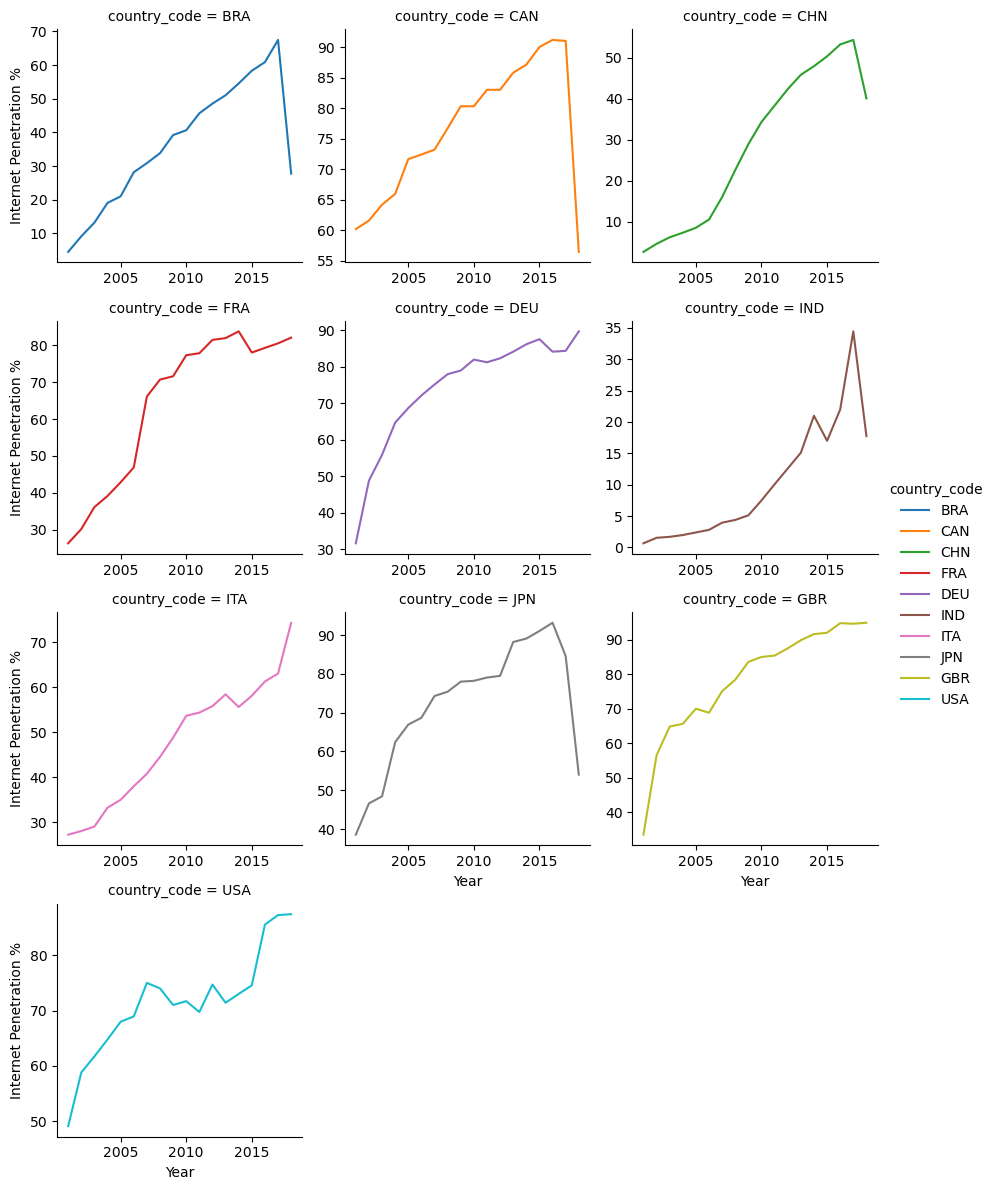

In [17]:
#Creating a facet grid of internet penetration over time
plotting_df2=df2.copy()
plotting_df2=plotting_df2[plotting_df2["year"]>2000]
graph_1=sns.FacetGrid(plotting_df2,col="country_code",col_wrap=3,hue="country_code",sharey=False,sharex=False)
graph_1=(graph_1.map(sns.lineplot,"year","internet_penetration").add_legend().set_axis_labels("Year","Internet Penetration %"))

## Probing a Correlation
Is there a correlation between income of the general public and internet penetration? Let's examine. I will be using gdp_per_capita to measure income.

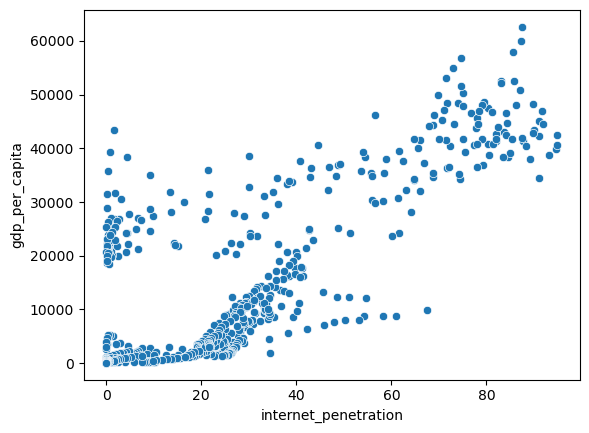

In [18]:
#Creating a dataset copy to prevent manipulation of original dataset
plotting_df3=df2.copy()
sns.scatterplot(x="internet_penetration",y="gdp_per_capita",data=plotting_df3)
plt.show()


The scatterplot above shows a nearly positive correlation between internet penetration and GDP per capita. To quantify this correlation, let's calculate the pearson coefficient of the 2 quantitative variables- gdp per capita and internet penetration

In [21]:
#Calculating Pearson Correlation
corr_gdppercap_internetpen,p=pearsonr(df2.gdp_per_capita,df2.internet_penetration)
print("Pearson Correlation=",corr_gdppercap_internetpen)

Pearson Correlation= 0.7560738944261491


Generally, a Pearson Correlation greater than 0.6 indicates a STRONG linear association. Evidently, we can say that there is a linear relationship between gdp_per_capita and internet penetration. In other words, increasing internet penetration has lead to increasing incomes.

## Creating a linear regression model to predict gdp_per_capita using internet penetration

Mean Squared Error: 104713380.52416633
R-squared: 0.5075792586664271
Coefficients: [460.76762517]
Intercept: 2366.444207405655
         Actual     Predicted
11791  1896.390  14486.025404
4296   2750.720  13738.898284
11783  4138.170  15486.694900
5169    274.111   2366.444207
3986   9763.330  17834.764193


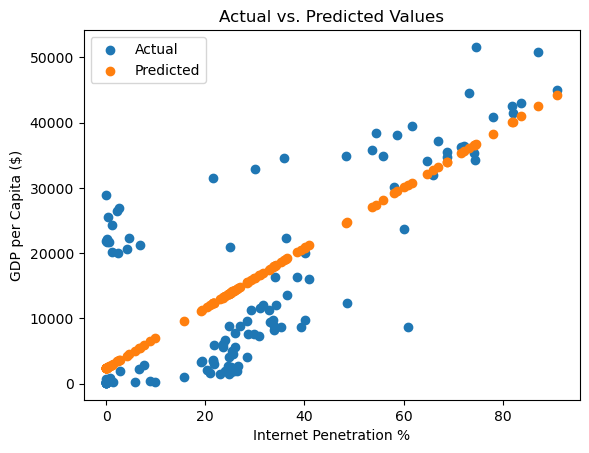

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X=df2[["internet_penetration"]]
y=df2["gdp_per_capita"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% train, 20% test

#Create and train the linear regression model (using scikit-learn)
model = LinearRegression()
model.fit(X_train, y_train)

#Make predictions on the test set
y_pred = model.predict(X_test)

#Evaluate the model (using scikit-learn metrics)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

#the coefficients (for interpretation)
print(f"Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_}")

#Create a dataframe for better visualization
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(results_df.head())

#Plotting the results
plt.scatter(X_test['internet_penetration'], y_test, label='Actual') 
plt.scatter(X_test['internet_penetration'], y_pred, label='Predicted')
plt.xlabel('Internet Penetration %')
plt.ylabel('GDP per Capita ($)')
plt.legend()
plt.title('Actual vs. Predicted Values')
plt.show()


# Conclusions
* The World Bank dataset needed to be cleaned by handling negative/ suspect values and imputing missing values with realistic data points.
* The countries have been segregated by income group. Using a histogram, I was able to see that high income OECD countries have more earners in the $ 25000 - $ 75000 category than high income non OECD countries
* While the entire dataset had 211 countries, I had to slice the dataset to contain only the top 10 economies to focus my analysis.
* GDPs for the top 10 countries were plotted over time to check for inflection points.
* Post dot com revolution (~in 2000); I was able to see the internet adoption over time for the top 10 economies.India stoodout in this visual, seeing an exponential growth while others saw linear growth.
* There is a positive linear correlation between gdp per capita and internet penetration as shown by the linear regression model metrics.

# Next Ste